<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Testing" data-toc-modified-id="Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

In [1]:
from miri3d.miri3d.cubepar import make_cubepar

# Testing

In [3]:
import numpy as np
import os
from astropy.io import fits
import miricoord.mrs.mrs_tools as mmrs
import miricoord.tel.tel_tools as jwst
import miricoord.mrs.makesiaf.makesiaf_mrs as makesiaf
from array_indices import *
import idlwrap
import pandas as pd
from miri3d.cubepar import make_cubepar

In [4]:
def output_result(maxoffset, channel, phase_pix, phase_slice, covmap):
    if (channel == '1A'): psf = 0.31
    if (channel == '1B'): psf = 0.31
    if (channel == '1C'): psf = 0.31
    if (channel == '2A'): psf = 0.31 * (8.90 / 8.0)
    if (channel == '2B'): psf = 0.31 * (10.28 / 8.0)
    if (channel == '2C'): psf = 0.31 * (11.87 / 8.0)
    if (channel == '3A'): psf = 0.31 * (13.67 / 8.0)
    if (channel == '3B'): psf = 0.31 * (15.80 / 8.0)
    if (channel == '3C'): psf = 0.31 * (18.24 / 8.0)
    if (channel == '4A'): psf = 0.31 * (21.10 / 8.0)
    if (channel == '4B'): psf = 0.31 * (24.72 / 8.0)
    if (channel == '4C'): psf = 0.31 * (28.82 / 8.0)

    print('Max offset (arcsec): ' + str(maxoffset))
    print('Max offset (FWHM): ' + str(maxoffset / psf))

    pixfile = 'phase_pix_' + channel + '.fits'
    slicefile = 'phase_slice_' + channel + '.fits'
    covfile = 'covmap_' + channel + '.fits'
    
    try:
        fits.writeto(pixfile, data=phase_pix)
    except:
        print("File '"+pixfile+"' already exists. \n")

    try:
        fits.writeto(slicefile, data=phase_slice)
    except:
        print("File '"+slicefile+"' already exists. \n")

    try:
        fits.writeto(covfile, data=covmap)
    except:
        print("File '"+covfile+"' already exists. \n")

    return


In [52]:
def make_covmap(goodval, wave_phase, pixel_phase):
    
    covmap = np.zeros_like(wave_phase)
    
    for i,j in zip(goodval[0],goodval[1]):
        
        wavevals = wave_phase[:, i, j]
        pixvals = pixel_phase[:, i, j]

        hit_w = np.zeros(100)

        for m in range(0, wavevals.size):
            wval = int(round(wavevals[m] * 100))

            if (wval == 100):
                wval = 0  # Wrap around

            if (wval < 25):
                hit_w[wval:wval + 25] = 1
                hit_w[0:wval] = 1
                hit_w[100 - (25 - wval):] = 1

            if ((wval >= 25) and (wval < 75)):
                hit_w[wval - 25:wval + 25] = 1

            if (wval >= 75):
                hit_w[wval - 25:wval] = 1
                hit_w[wval:] = 1
                hit_w[0:wval - 75] = 1

        hit_p = np.zeros(100)

        for m in range(0, pixvals.size):
            pval = int(round(pixvals[m] * 100))

            if (pval == 100):
                pval = 0  # ; Wrap around

            if (pval < 25):
                hit_p[pval:pval + 25] = 1
                hit_p[0:pval] = 1
                hit_p[100 - (25 - pval):] = 1

            if ((pval >= 25) and (pval < 75)):
                hit_p[pval - 25:pval + 25] = 1

            if (pval >= 75):
                hit_p[pval - 25:pval] = 1
                hit_p[pval:] = 1
                hit_p[0:pval - 75] = 1

        temp_w = idlwrap.where(hit_w == 1)
        nhit_w = len(temp_w)

        temp_p = idlwrap.where(hit_p == 1)
        nhit_p = len(temp_p)

        covmap[0,i,j] = nhit_w / 100.
        covmap[1,i,j] = nhit_p / 100.

    return covmap

In [70]:
def make_phase_im(rall, deall, racen, decen, dra, ddec, nra, ndec, lam, ndith,channel):
    phase_slice = np.zeros((ndith, ndec, nra))
    phase_pix = np.zeros((ndith, ndec, nra))
    phase_wave = np.zeros((ndith, ndec, nra))

    for i in range(0, ndith):
        # Transform to V2,V3 locations
        # WARNING; code will fail if ROLL != 0
        # Note that we MUST do -dra and +ddec cuz of how the Ideal frame is defined!!

        v2all, v3all, _ = jwst.jwst_radectov2v3(rall, deall, v2ref=-8.3942412 * 60, v3ref=-5.3123744 * 60,
                                                rollref=1e-5, raref=racen - dra[i], decref=decen + ddec[i])

        v2 = v2all.reshape(ndec, nra)
        v3 = v3all.reshape(ndec, nra)

        # Tranform to a,b locations
        aall, ball = mmrs.v2v3toab(v2all, v3all, channel)

        a = aall.reshape(ndec, nra)
        b = ball.reshape(ndec, nra)
            
        wavemin, wavemax = make_cubepar.waveminmax(channel)
        num = len(aall)
        lam = np.linspace(wavemin, wavemax, num)
        
        alin = np.zeros_like(aall)#*aall[0]

        vals = mmrs.abltoxy(alin, ball, lam, channel)

        phase_slice[i, :, :] = vals['slicephase'].reshape(ndec, nra) + 0.5
        phase_pix[i, :, :] = vals['pixelphase'].reshape(ndec, nra) + 0.5
        phase_wave[i, :, :] = vals['wavephase'].reshape(ndec, nra) + 0.5


    return phase_slice, phase_pix, phase_wave

In [42]:
rootdir=False
siafdir=False
write_result=False
channel='1A'
dith=False
wave=False
da=None
db=None

#set root and siaf directories
if rootdir == False:
    rootdir = os.getenv('MIRICOORD_DATA_DIR')
if siafdir == False:
    siafdir = os.getenv('MIRICOORD_DATA_DIR')

#
if dith == False:
    dith = [1,2]

ndith = len(dith)

#read in list of dithers
dithers = pd.read_csv('mrs_dithers.txt',header=2,sep='\s+',index_col=0)

#convert dithers to ra/dec
dra = dithers.dXIdeal[dith].array / 3600.
ddec = dithers.dYIdeal[dith].array / 3600.

siaf = makesiaf.create_siaf_oneband(channel)

#define shape of channel in alpha/beta
maxalpha = siaf['inscr_alpha_corners'][0] * 2
minalpha = siaf['inscr_alpha_corners'][2] * 2
maxbeta = siaf['inscr_beta_corners'][0] * 2
minbeta = siaf['inscr_beta_corners'][2] * 2

racen = 45.
decen = 0.
# WARNING- this code will fail if DEC != 0 !!!!
dtheta = 0.02

#number of pix in ra/dec dims
nra = int(np.abs(maxalpha - minalpha) / dtheta)
ndec = int(np.abs(maxbeta - minbeta) / dtheta)

#define the wavelength on each pixel
if wave != False:
    lam = np.ones((nra * ndec)) * wave
else:
    lam = np.ones((nra * ndec)) * -1

if (da != None) and (db != None):
    v2, v3 = mmrs.abtov2v3(da, db, channel)

    zpv2, zpv3 = mmrs.abtov2v3(0, 0, channel)

    zpx, zpy = mmrs.v2v3_to_xyideal(zpv2, zpv3)

    tempx, tempy = mmrs.v2v3_to_xyideal(v2, v3)

    dra = (tempx - zpx) / 3600.
    ddec = (tempy - zpy) / 3600.


#define actual ra/dec range
ra = (np.arange(nra) * dtheta + minalpha) / 3600. + racen
dec = (np.arange(ndec) * dtheta + minbeta) / 3600. + decen

#redefine center
racen = (min(ra) + max(ra)) / 2.
decen = (min(dec) + max(dec)) / 2.

#create a cube of ra/dec coordinates
skyloc = np.zeros((ndith, ndec, nra))

for i in range(0, nra - 1):
    skyloc[0, :, i] = ra[i]

for i in range(0, ndec - 1):
    skyloc[1, i, :] = dec[i]

rall = skyloc[0, :, :].reshape(nra * ndec)
deall = skyloc[1, :, :].reshape(nra * ndec)

In [71]:
# construct phase images
slice_phase, pixel_phase, wave_phase = make_phase_im(rall, deall, racen, decen, dra, ddec, nra, ndec, lam, ndith,channel)

In [33]:
from matplotlib import pyplot as plt

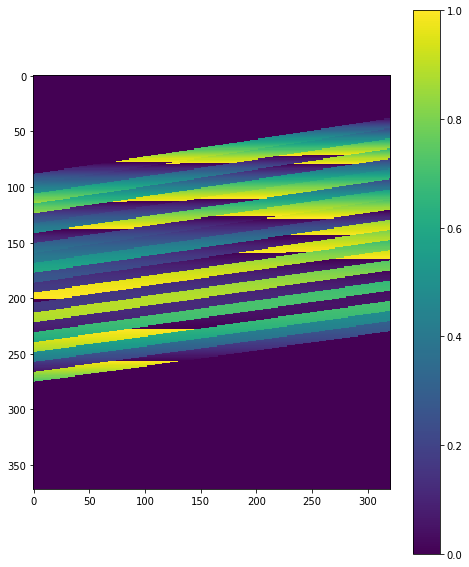

In [83]:
plt.figure(figsize=(8,10))

plt.imshow(pixel_phase[0],vmin=0,vmax=1)
plt.colorbar()

In [76]:
temp = np.sum(wave_phase, axis=0)
goodval = np.where(temp > -10)

In [78]:
#construct coverage map
covmap = make_covmap(goodval, wave_phase, pixel_phase)

temp = covmap[0, :, :]
indx = np.where(temp!=0)
nindx = len(indx[0])
print('Coverage area: ' + str(nindx * dtheta * dtheta) + ' arcsec^2')

offsets = np.sqrt((dra - dra[0]) ** 2 + (ddec - ddec[0]) ** 2)
maxoffset = max(offsets) * 3600.

if write_result == True:
    output_result(maxoffset, channel, phase_pix, phase_slice, covmap)

Coverage area: 17.76 arcsec^2


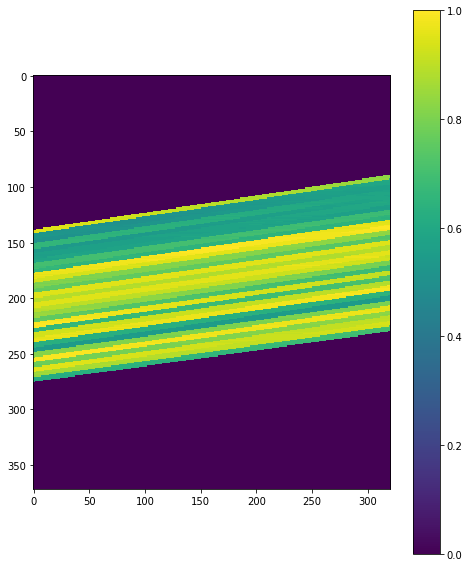

In [86]:
plt.figure(figsize=(8,10))

plt.imshow(covmap[1],vmin=0,vmax=1)
plt.colorbar()